In [1]:
import numpy as np
import scipy as sc
import os
import math
import cv2
import matplotlib.pyplot as plt
import dlib
from numpy.linalg import svd, inv
from scipy.spatial import ConvexHull

np.set_printoptions(suppress=True)
%matplotlib inline

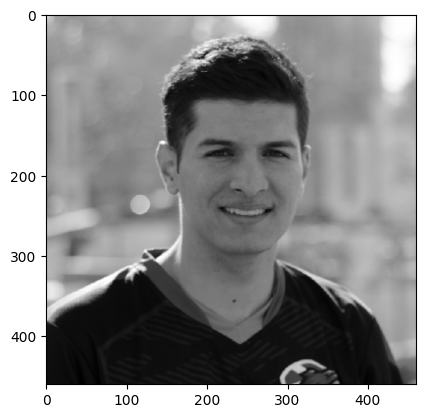

In [5]:
img1_f = 'sources/raoul.png'
img1 = cv2.cvtColor(cv2.cvtColor(cv2.imread(img1_f), cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img1, cmap='gray')

Found 1 Faces!


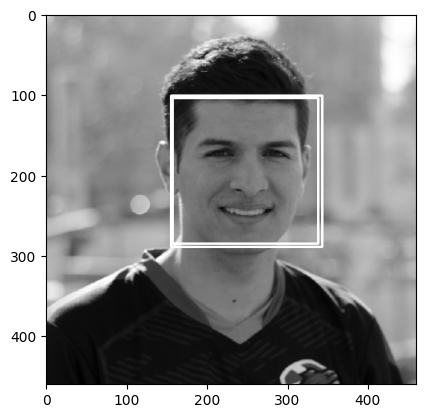

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(
        img1,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

print("Found {0} Faces!".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(img1, (x, y), (x+w, y+h), (255, 0, 0), 2)
    roi_img = cv2.cvtColor(cv2.imread(img1_f), cv2.COLOR_BGR2RGB)[y:y+h, x:x+w]
    
    
plt.figure()
plt.imshow(img1, cmap='gray')

In [ ]:
#TODO Require 